In [45]:
from __future__ import print_function

import argparse
import torch
import pickle 
import numpy as np 
import os 
import math 
import random 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.io

import data 

from sklearn.decomposition import PCA
from torch import nn, optim
from torch.nn import functional as F

from detm import DETM
from utils import nearest_neighbors, get_topic_coherence

import pandas as pd

In [2]:
%matplotlib inline
from sklearn.manifold import TSNE


In [59]:
root_dir = '/home/yiyi/nlp_tm/'

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
token_file = os.path.join('../../preprocessed_data', 'bow_tokens')
count_file = os.path.join('../../preprocessed_data', 'bow_counts')
time_file = os.path.join('../../preprocessed_data', 'bow_timestamps')

In [5]:
tokens = scipy.io.loadmat(token_file)['tokens'].squeeze()
counts = scipy.io.loadmat(count_file)['counts'].squeeze()
times = scipy.io.loadmat(time_file)['timestamps'].squeeze()

In [7]:
model_path = '/home/yiyi/nlp_tm/results/detm_twitter_K_50_Htheta_800_Optim_adam_Clip_0.0_ThetaAct_relu_Lr_0.005_Bsz_1000_RhoSize_300_L_3_minDF_10_trainEmbeddings_1_val_ppl_2638.9_epoch_20'

In [8]:
with open(model_path, 'rb') as f:
    model = torch.load(f)

In [9]:
model.to(device)

DETM(
  (t_drop): Dropout(p=0.0, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=20865, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=20915, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=50, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=50, bias=True)
  (q_eta_map): Linear(in_features=20865, out_features=200, bias=True)
  (q_eta): LSTM(200, 200, num_layers=3)
  (mu_q_eta): Linear(in_features=250, out_features=50, bias=True)
  (logsigma_q_eta): Linear(in_features=250, out_features=50, bias=True)
)

In [10]:
with open(os.path.join('/home/yiyi/nlp_tm/preprocessed_data', 'vocab.pkl'), 'rb') as f:
        vocab = pickle.load(f)

In [11]:
vocab_size = len(vocab)

In [12]:
len(tokens)

360097

In [13]:
times

array([0, 0, 0, ..., 7, 7, 7])

In [14]:
rnn_inp = data.get_rnn_input(
    tokens, counts, times, 8, vocab_size, len(tokens))


/home/yiyi/nlp_tm/models/DETM/data.py:117: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  tmp = (times_batch == t).nonzero()


idx: 0/361
idx: 20/361
idx: 40/361
idx: 60/361
idx: 80/361
idx: 100/361
idx: 120/361
idx: 140/361
idx: 160/361
idx: 180/361
idx: 200/361
idx: 220/361
idx: 240/361
idx: 260/361
idx: 280/361
idx: 300/361
idx: 320/361
idx: 340/361
idx: 360/361


In [15]:

def _eta_helper(rnn_inp):
    inp = model.q_eta_map(rnn_inp).unsqueeze(1)
    hidden = model.init_hidden()
    output, _ = model.q_eta(inp, hidden)
    output = output.squeeze()
    etas = torch.zeros(model.num_times, model.num_topics).to(device)
    inp_0 = torch.cat([output[0], torch.zeros(model.num_topics,).to(device)], dim=0)
    etas[0] = model.mu_q_eta(inp_0)
    for t in range(1, model.num_times):
        inp_t = torch.cat([output[t], etas[t-1]], dim=0)
        etas[t] = model.mu_q_eta(inp_t)
    return etas

In [16]:
etas= _eta_helper(rnn_inp)

In [17]:
def get_theta(eta, bows):
    model.eval()
    with torch.no_grad():
        inp = torch.cat([bows, eta], dim=1)
        q_theta = model.q_theta(inp)
        mu_theta = model.mu_q_theta(q_theta)
        theta = F.softmax(mu_theta, dim=-1)
        return theta   

In [65]:
# get the mats for plot word evolution
output_dir = os.path.join(root_dir, 'results', 'K_50_TR_1')

model.eval()
with torch.no_grad():
    alpha = model.mu_q_alpha.to(device)
    scipy.io.savemat(os.path.join(output_dir, 'alpha.mat'), {'values':alpha.cpu().numpy()}, do_compression=True)
    beta = model.get_beta(alpha).cpu().numpy()
    scipy.io.savemat(os.path.join(output_dir, 'beta.mat'), {'values':beta}, do_compression=True)
    rho = model.rho.weight.cpu().numpy()
    scipy.io.savemat(os.path.join(output_dir, 'rho.mat'), {'values': rho}, do_compression=True)
    

In [18]:
indices = torch.split(torch.tensor(range(len(tokens))), 1000)

In [20]:
theta_weights = []

In [21]:
counter =1
model.eval()
with torch.no_grad():
    alpha=model.mu_q_alpha

    for idx, ind in enumerate(indices):
        data_batch, times_batch = data.get_batch(
                        tokens, counts, ind, len(vocab),300, temporal=True, times=times)
        sums = data_batch.sum(1).unsqueeze(1)

        normalized_data_batch = data_batch / sums

        eta_td = etas[times_batch.type('torch.LongTensor')]
        theta = get_theta(eta_td, normalized_data_batch).to(device)
        theta = theta.cpu().numpy()
        theta_weights.append(theta)
        counter+=1
        print(f'{counter}\r')

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [29]:
theta_weights_list = []
for w in theta_weights:
    for i in w:
        theta_weights_list.append(i)

In [30]:
theta_weights_arr = np.stack(theta_weights_list, axis=0)

In [31]:
theta_weights_arr.shape

(360097, 50)

In [38]:
inds = np.argmax(theta_weights_arr, axis=1)

In [41]:
np.argsort(theta_weights_arr, axis=1)[0]

array([32, 22,  2, 24,  1, 14, 38, 12, 15, 30, 43, 41, 26,  4, 35,  5, 19,
       40, 16, 45,  9, 31, 49,  8, 25, 27, 42,  0, 20,  3, 18, 23, 33,  7,
       46, 17, 39, 36, 34, 47, 28, 10, 13, 37, 29, 44, 21, 48, 11,  6])

In [35]:
theta_weights_arr[0]

array([0.01496155, 0.00759155, 0.00641898, 0.016062  , 0.00985176,
       0.01020938, 0.10939208, 0.0178032 , 0.01361099, 0.01186638,
       0.02389051, 0.0993919 , 0.00825001, 0.02538348, 0.0078512 ,
       0.00841665, 0.01143228, 0.01844979, 0.01617335, 0.01032079,
       0.01499987, 0.06256872, 0.00571574, 0.01628733, 0.00744095,
       0.01400182, 0.00965179, 0.01411745, 0.02354261, 0.02713039,
       0.00888361, 0.0121347 , 0.00537031, 0.01639384, 0.0215896 ,
       0.00989649, 0.02096538, 0.02565662, 0.00786678, 0.01904708,
       0.01110439, 0.00932817, 0.01460308, 0.00922867, 0.03579482,
       0.01148926, 0.0179389 , 0.02327344, 0.063618  , 0.0130324 ],
      dtype=float32)

In [42]:
inds[-9:]

array([47, 47, 10, 47, 47, 10, 10, 10, 10])

In [43]:
len(inds)

360097

In [54]:
df = pd.read_csv('/home/yiyi/nlp_tm/datasets/df_detm_ids.csv', index_col=0)

In [56]:
len(df)

360097

In [57]:
df['topic']= inds

In [58]:
df.head()

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic
id,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,6
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,6
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,6
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,6
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,6


In [60]:
df.to_csv(os.path.join(root_dir, 'datasets/df_detm_topics.csv'))

In [50]:
from collections import Counter

In [52]:
sorted(Counter(inds).items())

[(1, 3),
 (2, 31),
 (3, 10),
 (4, 23444),
 (5, 10),
 (6, 28837),
 (7, 17366),
 (8, 189),
 (9, 89811),
 (10, 53082),
 (11, 2),
 (15, 144),
 (18, 2),
 (19, 113),
 (20, 53644),
 (22, 16272),
 (23, 3),
 (24, 1),
 (29, 1),
 (30, 49),
 (31, 1558),
 (33, 8),
 (34, 457),
 (36, 27),
 (37, 43),
 (38, 46),
 (41, 888),
 (43, 5),
 (46, 39324),
 (47, 34722),
 (48, 1),
 (49, 4)]

# plot word_evolution

In [68]:
with open(os.path.join(root_dir, 'preprocessed_data/timestamps.pkl'), 'rb')as f:
    timelist = pickle.load(f)

In [69]:
print('timelist: ', timelist)
T = len(timelist)
ticks = [str(x) for x in timelist]
print('ticks: ', ticks)

timelist:  [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
ticks:  ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']


In [70]:
data_file = os.path.join(root_dir, 'preprocessed_data')
vocab, train, valid, test = data.get_data(data_file, temporal=True)
vocab_size = len(vocab)

In [77]:
beta.shape

(50, 8, 20865)

In [76]:
print('Topic Immigration...')
num_words = 10
for t in range(8):
    gamma = beta[45, t, :]
    top_words = list(gamma.argsort()[-num_words+1:][::-1])
    topic_words = [vocab[a] for a in top_words]
    print('Time: {} ===> {}'.format(timelist[t], topic_words)) 

Topic Immigration...
Time: 2013 ===> ['rtw', 'cwmassacre', 'batman', 'bulgarian', 'americanhorrorstoryasylum', 'italy', 'encounters', 'inspector', 'kurdistan']
Time: 2014 ===> ['childrenofsyria', 'bbcqt', 'fitness', 'embracefamily', 'london', 'coven', 'depress', 'unrest', 'bind']
Time: 2015 ===> ['migrant', 'mediterranean', 'border', 'asylum', 'uk', 'question', 'people', 'eu', 'today']
Time: 2016 ===> ['trevifountain', 'barbudoybigotudo', 'greater', 'marchforeurope', 'hyde', 'kiel', 'monument', 'cinnamon', 'cardiff']
Time: 2017 ===> ['warsaw', 'louvre', 'neuschwanstein', 'lifestyle', 'entrance', 'instadaily', 'fee', 'bike', 'hungry']
Time: 2018 ===> ['refugee', 'dracobanks', 'sevilla', 'caravan', 'cobblestone', 'brixton', 'wheninberlin', 'aroundtheworld', 'followbon']
Time: 2019 ===> ['paris', 'themusketeers', 'syria', 'organization', 'email', 'anger', 'solve', 'iameuropean', 'nationalism']
Time: 2020 ===> ['world', 'update', 'long', 'asylum', 'people', 'food', 'party', 'group', 'momen

In [26]:
def nearest_neighbors(word, embeddings, vocab, num_words):
    vectors = embeddings.cpu().numpy() 
    index = vocab.index(word)
    query = embeddings[index].cpu().numpy() 
    ranks = vectors.dot(query).squeeze()
    denom = query.T.dot(query).squeeze()
    denom = denom * np.sum(vectors**2, 1)
    denom = np.sqrt(denom)
    ranks = ranks / denom
    mostSimilar = []
    [mostSimilar.append(idx) for idx in ranks.argsort()[::-1]]
    nearest_neighbors = mostSimilar[:num_words]
    nearest_neighbors = [vocab[comp] for comp in nearest_neighbors]
    return nearest_neighbors

In [34]:
model.eval()
with torch.no_grad():
    embeddings = model.rho.weight
    vectors = embeddings.cpu().numpy()
    for word in ['immigrant', 'refugee', 'exile', 'migrant', 'asylum', 'uk', 'eu', 'europe']:
        neighbors = nearest_neighbors(word, embeddings, vocab, 10)
        print(word, ': ', neighbors)

immigrant :  ['immigrant', 'fashionshow', 'beachclub', 'criminals', 'lagodigarda', 'finedine', 'giverny', 'teamapex', 'nineveh', 'hoy']
refugee :  ['refugee', 'gna', 'cinnamon', 'tweeting', 'gorran', 'donnie', 'damien', 'munition', 'cray', 'blueandwhite']
exile :  ['exile', 'asylum', 'uk', 'people', 'migrant', 'good', 'great', 'love', 'human', 'work']
migrant :  ['migrant', 'uk', 'asylum', 'eu', 'people', 'time', 'seeker', 'good', 'work', 'british']
asylum :  ['asylum', 'uk', 'good', 'seeker', 'migrant', 'work', 'time', 'day', 'people', 'great']
uk :  ['uk', 'asylum', 'people', 'work', 'migrant', 'good', 'today', 'seeker', 'year', 'country']
eu :  ['eu', 'migrant', 'uk', 'people', 'seeker', 'asylum', 'time', 'work', 'country', 'good']
europe :  ['europe', 'ambience', 'bringing', 'mentoring', 'spreadlove', 'szczecin', 'hours', 'fragmentation', 'quay', 'eccentric']


In [36]:
keywords=  [ 'immigrant', 'immigrants',  'refugee', 'refugees','asylum',
      'migrant', 'migrants', 'internally displaced', 'UNHCR', 'asylee',
      'asylees', 'Asylee',  'resettled', 'resettlements',
      'immigration', 'Ateh', 're settlement', 'resettle', 'resettles',
      'Dadaab', 'statelessness', 'Hagadera' , 'Domiz',
      'émigré', 'exile', 'displaced person', 'deserter', 'pariah', 'pariahs' ]

In [39]:
keywords = list(set([k.lower() for k in keywords]))

In [40]:
len(keywords)

28

In [43]:
keywords_selected = []
for k in keywords: 
    if k in vocab:
        keywords_selected.append(k)

In [89]:
keywords_ =['immigrant', 'refugee', 'immigration', 'asylum', 'exile', 'migrant']

In [90]:
# vectors of whole embeddings.
indexes_keywords = [vocab.index(word) for word in keywords_]
queries = [vectors[index] for index in indexes_keywords] # vectors of the keywords

In [77]:
from sklearn import cluster
from sklearn import metrics

In [91]:
kmeans = cluster.KMeans(n_clusters=1, random_state=0).fit(queries)

In [92]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0], dtype=int32)

In [93]:
centroid = kmeans.cluster_centers_

In [81]:
centroid.shape

(1, 300)

In [82]:
vectors.shape

(20865, 300)

In [94]:
centroid = centroid[0]

In [95]:
centroid.shape

(300,)

In [96]:
ranks= vectors.dot(centroid).squeeze()
denom = centroid.T.dot(centroid).squeeze()
denom = denom*np.sum(vectors*2, 1)
ranks = ranks/denom

In [97]:
ranks.shape

(20865,)

In [98]:
mostSimilar = []
[mostSimilar.append(idx) for idx in ranks.argsort()[::-1]]
nearest_neighbors = mostSimilar[:50]
nearest_neighbors = [vocab[comp] for comp in nearest_neighbors]

In [99]:
nearest_neighbors

['roberts',
 'torycorruption',
 'starry',
 'nbd',
 'advanced',
 'vacant',
 'ecuadorian',
 'mummy',
 'girona',
 'board',
 'engerland',
 'scott',
 'corporate',
 'varenna',
 'rights',
 'congresswoman',
 'kafala',
 'christmaslight',
 'teatro',
 'agriculture',
 'irelands',
 'fleet',
 'hurts',
 'percussion',
 'calle',
 'outlook',
 'inane',
 'trumpban',
 'verification',
 'lanzarote',
 'starowkatorun',
 'woohoo',
 'triangle',
 'silva',
 'guard',
 'noun',
 'cartooninghumanright',
 'exporter',
 'adjective',
 'senegal',
 'barnet',
 'bot',
 'wartime',
 'nowadays',
 'humza',
 'rooney',
 'site',
 'partytime',
 'messy',
 'fridaynight']

In [102]:
query_arr = np.array(queries)

In [103]:
query_arr.shape

(6, 300)

In [100]:
from sklearn.manifold import TSNE

In [104]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=7)

In [105]:
T = tsne.fit_transform(query_arr)

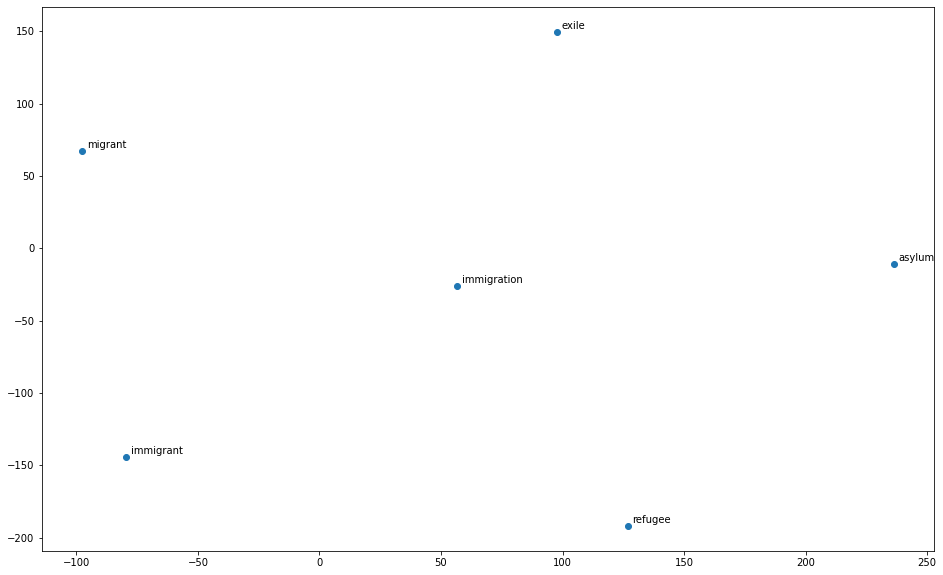

In [106]:
plt.figure(figsize=(16,10))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(keywords_, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+2, y+2), xytext=(0, 0), textcoords='offset points')